C:\Users\hello\AppData\Local\Temp\ipykernel_13520\4252983635.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate_clean, data_clean = wavfile.read("clean.wav")
C:\Users\hello\AppData\Local\Temp\ipykernel_13520\4252983635.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate_noised, data_noised = wavfile.read("cleanplusstreet.wav")


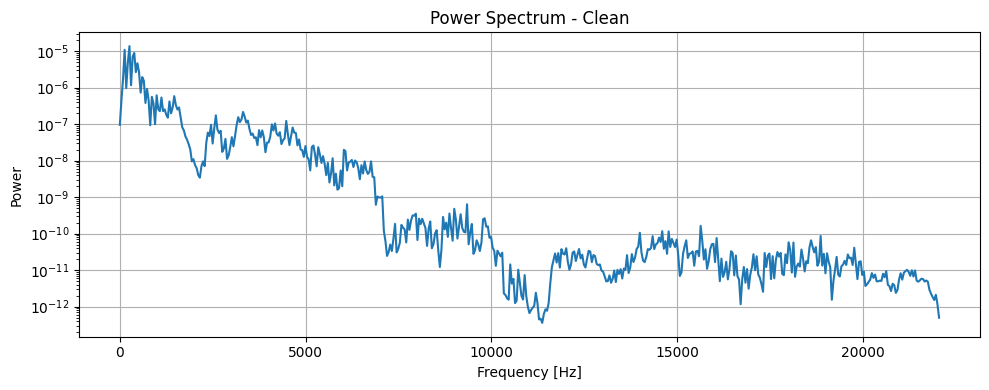

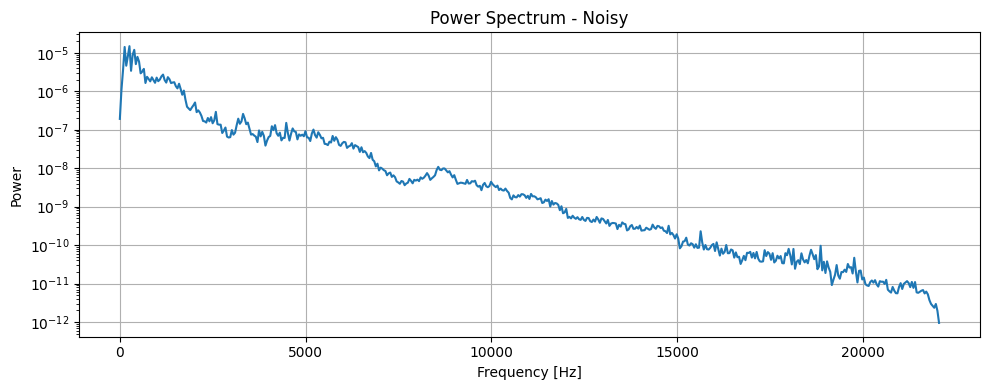

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram, correlate
from scipy.signal.windows import hamming
from numpy.fft import fft, ifft, rfft, irfft
import soundfile as sf

# Частотные диапазоны
freq_ranges = [
    (90, 180), (180, 233), (355, 710),
    (710, 1400), (1400, 2800), (2800, 5600), (5600, 11200)
]
x_labels = [f"{f1}-{f2} Hz" for f1, f2 in freq_ranges]

# Загрузка
rate_clean, data_clean = wavfile.read("clean.wav")
# rate_noised, data_noised = wavfile.read("noised.wav")
rate_noised, data_noised = wavfile.read("cleanplusstreet.wav")

if data_clean.ndim > 1:
    data_clean = data_clean[:, 0]
if data_noised.ndim > 1:
    data_noised = data_noised[:, 0]

data_clean = data_clean.astype(np.float32) / np.max(np.abs(data_clean))
data_noised = data_noised.astype(np.float32) / np.max(np.abs(data_noised))

def plot_power_spectrum(signal, rate, title):
    f, t, Sxx = spectrogram(signal, rate, nperseg=1024)
    power_spectrum = np.mean(Sxx, axis=1)
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, power_spectrum)
    plt.title(f"Power Spectrum - {title}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_power_spectrum(data_clean, rate_clean, "Clean")
plot_power_spectrum(data_noised, rate_noised, "Noisy")

In [71]:
# Приравняем сигналы по длине
min_len = min(len(data_clean), len(data_noised))
data_clean_trimmed = data_clean[:min_len]
data_noised_trimmed = data_noised[:min_len]

# Нормализуем сигналы
data_clean_trimmed  = data_clean_trimmed / np.max(np.abs(data_clean_trimmed))
data_noised_trimmed = data_noised_trimmed / np.max(np.abs(data_noised_trimmed))

# Сосчитаем корреляцию
corr = correlate(data_clean_trimmed, data_noised_trimmed, mode='valid')
corr /= (np.linalg.norm(data_clean_trimmed) * np.linalg.norm(data_noised_trimmed))

max_corr = np.max(corr)
print(max_corr)

0.6912818


C:\Users\hello\AppData\Local\Temp\ipykernel_13520\1656342525.py:4: UserWarning: nperseg = 1024 is greater than input length  = 417, using nperseg = 417
  f, t, Sxx = spectrogram(signal, rate, nperseg=1024)


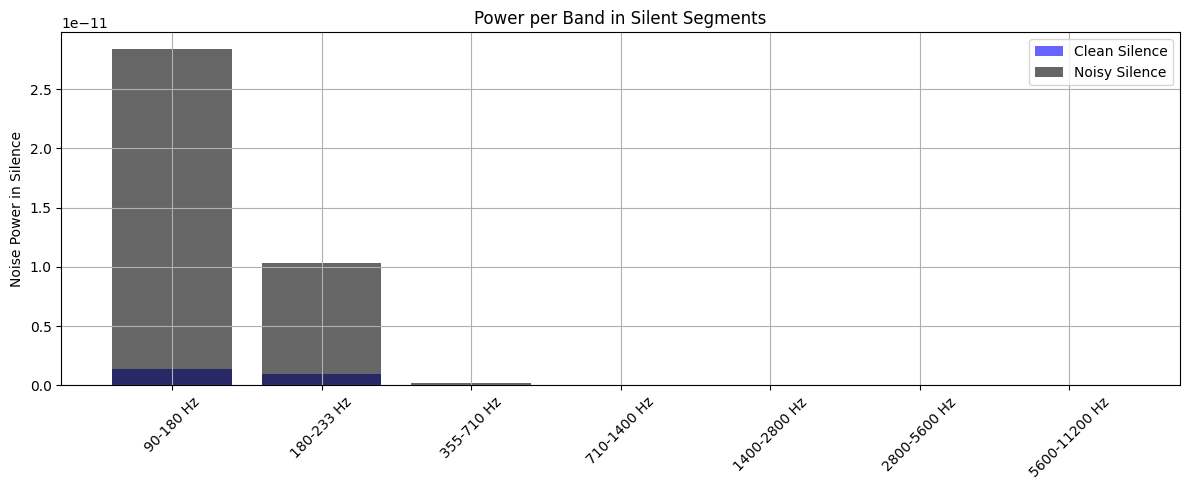

In [72]:
# Функция для извлечения "тихих" участков - по низкой энергии сигнала
# Анализ мощности в диапазонах
def band_power(signal, rate, ranges):
    f, t, Sxx = spectrogram(signal, rate, nperseg=1024)
    power_per_band = []
    for f_min, f_max in ranges:
        band_mask = (f >= f_min) & (f <= f_max)
        power_per_band.append(np.mean(Sxx[band_mask]) if np.any(band_mask) else 0)
    return power_per_band

def extract_silence(signal, frame_size, rate, threshold_ratio=0.1):
    frame_length = int(frame_size * rate)
    frames = [signal[i:i + frame_length] for i in range(0, len(signal), frame_length)]
    rms_energy = [np.sqrt(np.mean(frame**2)) for frame in frames]
    threshold = np.median(rms_energy) * threshold_ratio
    silent_frames = [frames[i] for i, e in enumerate(rms_energy) if e < threshold]
    return np.concatenate(silent_frames) if silent_frames else np.array([])

# Извлекаем участки молчания
silence_clean = extract_silence(data_clean, 0.04, rate_clean)
silence_noised = extract_silence(data_noised, 0.04, rate_noised)

# Рассчитываем спектры для тишины
silence_clean_power = band_power(silence_clean, rate_clean, freq_ranges)
silence_noised_power = band_power(silence_noised, rate_noised, freq_ranges)

# Визуализация
plt.figure(figsize=(12, 5))
plt.bar(x_labels, silence_clean_power, alpha=0.6, label="Clean Silence", color="blue")
plt.bar(x_labels, silence_noised_power, alpha=0.6, label="Noisy Silence", color="black")
plt.xticks(rotation=45)
plt.ylabel("Noise Power in Silence")
plt.title("Power per Band in Silent Segments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\hello\AppData\Local\Temp\ipykernel_13520\1656342525.py:4: UserWarning: nperseg = 1024 is greater than input length  = 417, using nperseg = 417
  f, t, Sxx = spectrogram(signal, rate, nperseg=1024)
C:\Users\hello\AppData\Local\Temp\ipykernel_13520\1362848907.py:42: UserWarning: nperseg = 1024 is greater than input length  = 417, using nperseg = 417
  f_noise, _, Sxx_noise = spectrogram(silence_noised, rate_noised, nperseg=1024)


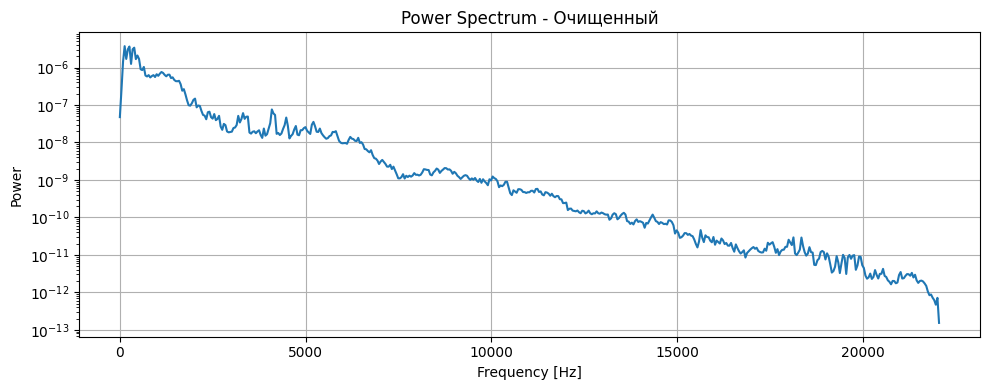

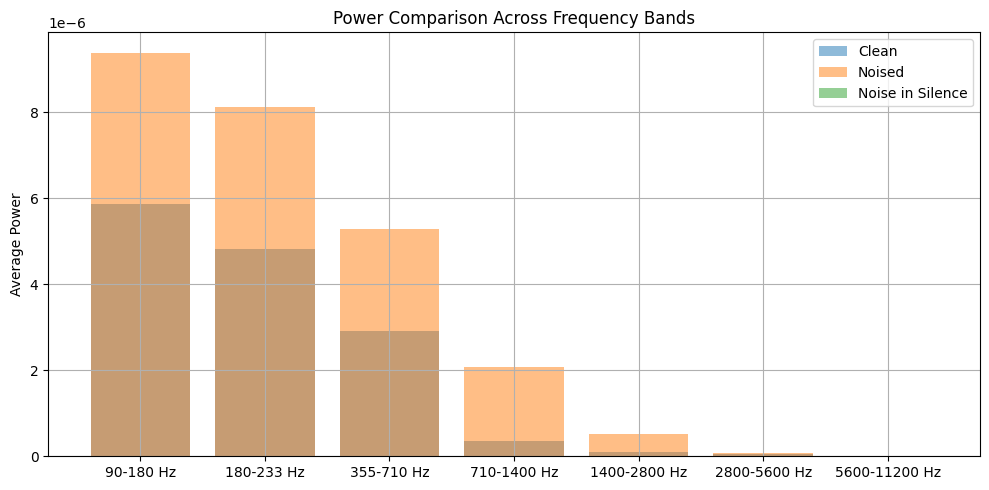

Correlation (Clean vs Noised): 0.6912828
Correlation (Clean vs Cleaned): 0.51287806
Correlation (Noised vs Cleaned): 0.75070924


In [82]:
# Анализ мощности
clean_power = band_power(data_clean, rate_clean, freq_ranges)
noised_power = band_power(data_noised, rate_noised, freq_ranges)

# Участки молчания
silence_clean = extract_silence(data_clean, 0.04, rate_clean)
silence_noised = extract_silence(data_noised, 0.04, rate_noised)
silence_clean_power = band_power(silence_clean, rate_clean, freq_ranges)
silence_noised_power = band_power(silence_noised, rate_noised, freq_ranges)
def spectral_subtraction(noised, noise_est, rate):
    frame_len = int(0.04 * rate)
    step = frame_len
    window = hamming(frame_len, sym=False)
    result = np.zeros_like(noised)
    for i in range(0, len(noised) - frame_len, step):
        frame = noised[i:i + frame_len] * window
        spectrum = rfft(frame)
        power = np.abs(spectrum) ** 2
        phase = np.angle(spectrum)

        # Подгонка длины спектра
        if len(noise_est) != len(power):
            noise_est_interp = np.interp(np.linspace(0, 1, len(power)), np.linspace(0, 1, len(noise_est)), noise_est)
        else:
            noise_est_interp = noise_est

        subtracted = np.maximum(power - noise_est_interp, 0)
        new_spectrum = np.sqrt(subtracted) * np.exp(1j * phase)
        reconstructed = irfft(new_spectrum)
        windowed = reconstructed * window
        result[i:i + frame_len] += windowed
    return result
def calculate_corr(sig1, sig2):
    min_len = min(len(sig1), len(sig2))
    sig1, sig2 = sig1[:min_len], sig2[:min_len]
    sig1 -= np.mean(sig1)
    sig2 -= np.mean(sig2)
    corr = correlate(sig1, sig2, mode='valid')
    corr /= (np.linalg.norm(sig1) * np.linalg.norm(sig2))
    return np.max(corr)
# Очистка сигнала
f_noise, _, Sxx_noise = spectrogram(silence_noised, rate_noised, nperseg=1024)
noise_estimate = np.mean(Sxx_noise, axis=1)
noise_interp = np.interp(np.fft.rfftfreq(int(0.04 * rate_noised)), f_noise, noise_estimate)
cleaned = spectral_subtraction(data_noised, noise_interp, rate_noised)
cleaned /= np.max(np.abs(cleaned))

# Сохранение
sf.write("cleaned_output.wav", cleaned, rate_noised)

plot_power_spectrum(cleaned,rate_noised, "Очищенный" )


# Корреляции
corr_clean_noised = calculate_corr(data_clean, data_noised)
corr_clean_cleaned = calculate_corr(data_clean, cleaned)
corr_noised_cleaned = calculate_corr(data_noised, cleaned)

# График
plt.figure(figsize=(10, 5))
plt.bar(x_labels, clean_power, alpha=0.5, label="Clean")
plt.bar(x_labels, noised_power, alpha=0.5, label="Noised")
plt.bar(x_labels, silence_noised_power, alpha=0.5, label="Noise in Silence")
plt.ylabel("Average Power")
plt.title("Power Comparison Across Frequency Bands")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Вывод корреляций
print("Correlation (Clean vs Noised):", corr_clean_noised)
print("Correlation (Clean vs Cleaned):", corr_clean_cleaned)
print("Correlation (Noised vs Cleaned):", corr_noised_cleaned)


In [83]:
def compute_power_spectrum(audio, sample_rate):
    n = len(audio)
    audio_fft = np.fft.rfft(audio)
    power_spectrum = np.abs(audio_fft) ** 2
    frequencies = np.fft.rfftfreq(n, d=1/sample_rate)
    return frequencies, power_spectrum


def calculate_articulation_index(audio, sample_rate):
    bands = [
        (100, 420), (420, 570), (570, 710), (710, 865), (865, 1030),
        (1030, 1220), (1220, 1410), (1410, 1600), (1600, 1780), (1780, 1960),
        (1960, 2140), (2140, 2320), (2320, 2550), (2550, 2900), (2900, 3300),
        (3300, 3660), (3660, 4050), (4050, 5010), (5010, 7250), (7250, 10000)
    ]

    frequencies, power_spectrum = compute_power_spectrum(audio, sample_rate)
    power_spectrum_db = 10 * np.log10(power_spectrum + np.finfo(float).eps)

    AI = 0
    for low, high in bands:
        mask = (frequencies >= low) & (frequencies <= high)
        band_power_db = power_spectrum_db[mask]
        if len(band_power_db) > 0:
            noise_level_db = np.mean(band_power_db)
            peak_level_db = np.max(band_power_db)
            delta_L = peak_level_db - noise_level_db
            normalized_delta_L = np.clip((delta_L + 30) / 60, 0, 1)  # +30 для сдвига в положительную область
            AI += normalized_delta_L
    AI /= len(bands)

    return AI

AI_clean = calculate_articulation_index(data_clean, rate_clean)
AI_noisy = calculate_articulation_index(data_noised, rate_noised)
AI_cleaned = calculate_articulation_index(cleaned, rate_noised)

print(f"\nИндекс артикуляции (AI) для чистой записи: {AI_clean:.4f}")
print(f"Индекс артикуляции (AI) для зашумлённой записи: {AI_noisy:.4f}")
print(f"Индекс артикуляции (AI) для очищенной записи: {AI_cleaned:.4f}")



Индекс артикуляции (AI) для чистой записи: 0.6860
Индекс артикуляции (AI) для зашумлённой записи: 0.7045
Индекс артикуляции (AI) для очищенной записи: 0.6965
